In [ ]:
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install statsmodels
!pip install prophet
!pip install torch

#### **Code Box 1: load the data and pre-processing (e.g.fill the missing values)**

- The data used here is from "./data/103.csv", which is the data on a single IP 103
- The attribute used here is the 'n_flows', which the number of flows on the IP 103
- At the end, it re-produce the Figure 10 in the paper. It helps to have a visual inspect the shape of the data.

Note: This step learn the code from the example provided by the paper


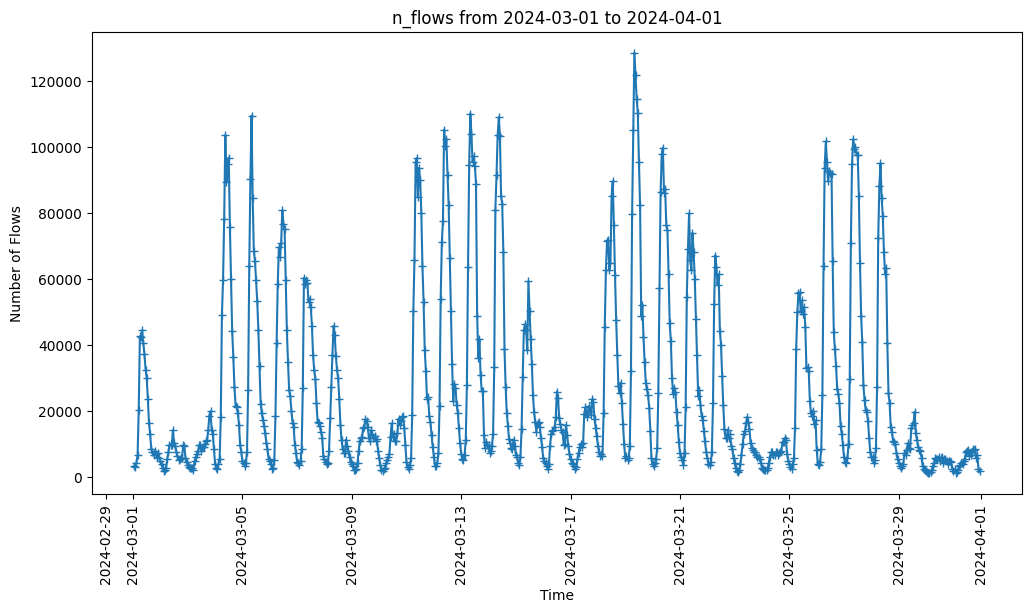

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

## re-use the function from the paper's example code
def fill_missing(train_df, train_time_ids):
    df_missing = pd.DataFrame(columns=train_df.columns)
    df_missing.id_time = train_time_ids[~train_time_ids.isin(train_df.id_time)].values
    
    for column in train_df.columns:
        if column == "id_time":
            continue
        if column in ["tcp_udp_ratio_packets","tcp_udp_ratio_bytes","dir_ratio_packets","dir_ratio_bytes"]:
            df_missing[column] = 0.5
        else:
            df_missing[column] = 0 # train_df[column].mean()
    
    return pd.concat([train_df, df_missing]).sort_values(by="id_time").reset_index()[train_df.columns]


##Load the time
df = pd.read_csv("./data/103.csv")

## Load the time file
df_times = pd.read_csv("./data/times_1_hour.csv")
df_times['time'] = pd.to_datetime(df_times['time'])
##display(df_times.head(2))

## fill the miss value: resue the code from example of the paper
df = fill_missing(df, df_times.id_time)
df['time'] = df_times['time']
df = df[['time'] + df.keys().drop('time').to_list()]
df['time'] = pd.to_datetime(df['time'])
##display(df.head(2))



# Plotting 'n_flows' over time, Fig.10 in the paper
# This serves the purpose to to have visual effect of the data to predict
start_date = '2024-03-01'
end_date = '2024-04-01'
mask = (df['time'] > start_date) & (df['time'] < end_date)
df_filtered = df.loc[mask]
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['time'], df_filtered['n_flows'], marker='+')
plt.title('n_flows from 2024-03-01 to 2024-04-01')
plt.xlabel('Time')
plt.ylabel('Number of Flows')
plt.xticks(rotation=90)
plt.show()


##### **Code Box 2: Define the evaluation metric: RMSE**

Root Mean Squared Error (RMSE)  is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

In [2]:
from sklearn.metrics import root_mean_squared_error

def evaluate_predictions(df, model_predictions, TS_METRIC, TRAINING_PERIOD, time_index_max):
    for method_name in model_predictions:
        predictions = model_predictions[method_name]
        tmp = df[(df.id_time >= TRAINING_PERIOD - 1) & (df.id_time < time_index_max)]
        y_true = tmp[TS_METRIC].values
        y_pred = predictions[:len(y_true)]    
        rmse = root_mean_squared_error(y_true, y_pred)
    
        print(f"{method_name} predictions length = {len(predictions)}")
        print(f"{method_name}     RMSE: {rmse:.4f}")


##### **Code Box 3: Define the LSTMModel**


In [10]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])  # Take last time step's output

class LSTMWrapper:
    def __init__(self, train_data, seq_len=48, hidden_size=128, num_layers=2,
                 dropout=0.2, epochs=50, lr=0.001, batch_size=32):
        self.seq_len = seq_len
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.scaler = MinMaxScaler()

        self.model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
        self._fit(train_data)

    def _fit(self, train_data):
        # Normalize data
        scaled = self.scaler.fit_transform(np.array(train_data).reshape(-1, 1)).flatten()

        # Create sliding window sequences
        X, y = [], []
        for i in range(len(scaled) - self.seq_len):
            X.append(scaled[i:i + self.seq_len])
            y.append(scaled[i + self.seq_len])
        X = torch.tensor(X).float().unsqueeze(-1)
        y = torch.tensor(y).float().unsqueeze(-1)

        dataset = TensorDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Training
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        loss_fn = nn.MSELoss()
        self.model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0
            for xb, yb in loader:
                optimizer.zero_grad()
                pred = self.model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            # if epoch%10 == 0:
            #     print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss / len(loader):.6f}")

        self.last_input = scaled[-self.seq_len:]  # save last input for forecasting

    def forecast(self, steps):
        self.model.eval()
        input_seq = self.last_input.copy()
        preds = []
        for _ in range(steps):
            inp = torch.tensor(input_seq[-self.seq_len:]).float().unsqueeze(0).unsqueeze(-1)
            with torch.no_grad():
                pred = self.model(inp).item()
            preds.append(pred)
            input_seq = np.append(input_seq, pred)
        return self.scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()



#### Code box 4: main step.
- it trains the model

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import time

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)


TRAINING_PERIOD = 744  #31 Days
TESTING_PERIOD = 168   #7 Days
TS_METRIC = 'n_flows'



#df.id_time.max() = 6717
time_index_max=df.id_time.max()
time_index_max=TRAINING_PERIOD+2*TESTING_PERIOD

print(f"df.id_time.max() = {df.id_time.max()}")
print(f"time_index_max = {time_index_max}")



model_to_evaluate=["SARIMA", "LSTM", "ExponentialSmoothing", "Prophet"]
#model_to_evaluate=["SARIMA"]
model_predictions = {model: [] for model in model_to_evaluate}
model_cost_train = {model: [] for model in model_to_evaluate}
model_cost_predict = {model: [] for model in model_to_evaluate}

tmp_index = 0
while tmp_index <= time_index_max - TRAINING_PERIOD:
    train_df = df[df.id_time < tmp_index + TRAINING_PERIOD]
    train_df = train_df[train_df.id_time >= tmp_index]
    train_data = train_df[TS_METRIC].to_numpy()

    if "SARIMA" in model_to_evaluate:
        ORDER = (1, 1, 1)
        SEASONAL_ORDER = (1, 1, 1, 168)
        start_time = time.time()
        model = SARIMAX(train_data, order=ORDER, seasonal_order=SEASONAL_ORDER)
        results = model.fit(disp=False)  
        model_cost_train["SARIMA"] += (time.time() - start_time)

        start_time = time.time()
        preds = list(results.forecast(steps=TESTING_PERIOD))
        model_predictions["SARIMA"] += preds 
        model_cost_predict["SARIMA"] += (time.time() - start_time)
        
    if "LSTM" in model_to_evaluate:
        start_time = time.time()
        lstm_model = LSTMWrapper(
        train_data, 
        seq_len=168, 
        hidden_size=128, 
        num_layers=2, 
        dropout=0.2, 
        epochs=50, 
        lr=0.001,
        batch_size=32
        )
        model_cost_train["LSTM"] += (time.time() - start_time)
        start_time = time.time()
        preds = list(lstm_model.forecast(steps=TESTING_PERIOD))
        model_predictions["LSTM"] += preds 
        model_cost_predict["LSTM"] += (time.time() - start_time)

    if "ExponentialSmoothing" in model_to_evaluate:
        start_time = time.time()
        ExponentialSmoothing_SEASONAL_PERIOD=168
        # Fit the Holt-Winters model to your training data
        holt_model = ExponentialSmoothing(
            train_data,
            trend="add",               # or "mul" if the trend is multiplicative
            seasonal="add",            # or "mul" depending on the seasonality type
            seasonal_periods=ExponentialSmoothing_SEASONAL_PERIOD  # e.g., 12 for monthly data with yearly cycle
        )
        holt_results = holt_model.fit()
        model_cost_train["ExponentialSmoothing"] += (time.time() - start_time)

        start_time = time.time()
        preds = list(holt_results.forecast(steps=TESTING_PERIOD))
        model_predictions["ExponentialSmoothing"] += preds 
        model_cost_predict["ExponentialSmoothing"] += (time.time() - start_time)

    if "Prophet" in model_to_evaluate:
        # Fit Prophet
        start_time = time.time()
        train_df['time'] = pd.to_datetime(train_df['time']).dt.tz_localize(None)
        train_df_new = pd.DataFrame({
            'ds': train_df['time'],  # This assumes 'time' is already in datetime format
            'y': train_df[TS_METRIC].values
        })
        prophet_model = Prophet(weekly_seasonality=True)  # Optional: daily, yearly, etc.
        prophet_model.fit(train_df_new)
        model_cost_train["Prophet"] += (time.time() - start_time)

        
        future = prophet_model.make_future_dataframe(periods=TESTING_PERIOD, freq='H')  # 'H' for hourly data
        forecast = prophet_model.predict(future)
        preds = forecast.tail(TESTING_PERIOD)['yhat'].tolist()
        model_predictions["Prophet"] += preds 
        model_cost_predict["Prophet"] += (time.time() - start_time)


    tmp_index += TESTING_PERIOD
    print(f"tmp_index = {tmp_index}")


evaluate_predictions(df, model_predictions, TS_METRIC, TRAINING_PERIOD, time_index_max)



df.id_time.max() = 6717
time_index_max = 1080
Epoch 1/50, Loss: 0.077393
Epoch 11/50, Loss: 0.004845
Epoch 21/50, Loss: 0.002980
Epoch 31/50, Loss: 0.002830
Epoch 41/50, Loss: 0.002313
tmp_index = 168
Epoch 1/50, Loss: 0.092800
Epoch 11/50, Loss: 0.006965
Epoch 21/50, Loss: 0.003642
Epoch 31/50, Loss: 0.003152
Epoch 41/50, Loss: 0.002977
tmp_index = 336
Epoch 1/50, Loss: 0.108033
Epoch 11/50, Loss: 0.007142
Epoch 21/50, Loss: 0.004226
Epoch 31/50, Loss: 0.003773
Epoch 41/50, Loss: 0.002959
tmp_index = 504
SARIMA predictions length = 504
SARIMA     RMSE: 16087.0539
LSTM predictions length = 504
LSTM     RMSE: 59703.2087
ExponentialSmoothing predictions length = 504
ExponentialSmoothing     RMSE: 21953.3606
Prophet predictions length = 504
Prophet     RMSE: 25255.5907
